In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
A_train = pd.read_csv('train.csv')
A_train.set_index('id', inplace = True)

In [3]:
A_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7382 entries, 66721 to 64745
Columns: 335 entries, Unnamed: 0 to AlDbXTlZ
dtypes: bool(1), int64(5), object(329)
memory usage: 18.9+ MB


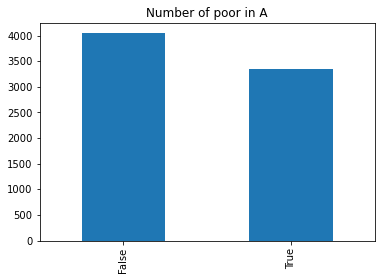

In [4]:
A_train.poor.value_counts().plot.bar(title = 'Number of poor in A')

In [5]:
#Data preprocessing

def standardized(df, numeric_only = True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    #subtract mean and divide by the standard deviation
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    return df

def pre_processing_data(df, enforce_cols = None):
    print('Input shape: \t{}'.format(df.shape))
    df = standardized(df)
    print('After standardization {}'.format(df.shape))
    #create dummy variable for the categories
    df = pd.get_dummies(df)
    print('After converting categoricals: \t{}'.format(df.shape))
    
    #match the test and training set
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)
        
        df.drop(to_drop, axis = 1, inplace = True)
        df = df.assign(**{c: 0 for c in to_add})
        
    df.fillna(0, inplace= True)
    
    return df

In [6]:
#here we convert the data to surveys
print("Country A")
Ax_train = standardized(A_train)
AX_train = pre_processing_data(Ax_train)

Country A
Input shape: 	(7382, 335)
After standardization (7382, 335)
After converting categoricals: 	(7382, 829)


In [7]:
AX_train["poor"] *= 1

In [8]:
AX_train.head()

,Unnamed: 0,nEsgxvAq,OMtioXZZ,YFMZwKrU,poor,TiwRslOh,wBXbHZmp_DkQlr,wBXbHZmp_JhtDR,SlDKnCuu_GUusz,SlDKnCuu_alLXR,...,JCDeZBXq_LPtkN,JCDeZBXq_UyAms,HGPWuGlV_WKNwg,HGPWuGlV_vkbkA,GDUPaBQs_qCEuA,GDUPaBQs_qQxrL,WuwrCsIY_AITFl,WuwrCsIY_GAZGl,AlDbXTlZ_aQeIm,AlDbXTlZ_cecIq
id,,,,,,,,,,,,,,,,,,,,,
66721,1.059419,-1.437328,0.327788,1.103348,0,-1.964543,0,1,1,0,...,0,1,0,1,0,1,1,0,0,1
75174,-0.408081,-0.410586,1.980361,1.103348,0,-0.175521,0,1,1,0,...,1,0,0,1,0,1,1,0,0,1
62573,-1.138240,-0.410586,0.327788,-0.012394,0,0.718989,0,1,1,0,...,1,0,0,1,0,1,1,0,0,1
50733,-0.860627,0.616157,0.327788,-0.012394,1,-0.622777,0,1,1,0,...,0,1,0,1,0,1,1,0,0,1
71295,0.222356,-0.410586,0.327788,1.103348,0,0.718989,0,1,1,0,...,0,1,0,1,0,1,1,0,1,0


In [9]:
a_train = AX_train.drop('poor', axis = 1)

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(a_train, AX_train['poor'], test_size=0.20, random_state=7, shuffle=True)

In [11]:
import random
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
from numpy import arange
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

from sklearn.model_selection import StratifiedKFold
n_fold = 4
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

params = {'bagging_temperature': 0.5,
            'depth': 7,
            'iterations': 498,
            'l2_leaf_reg': 25,
            'learning_rate': 0.04,
            'sampling_frequency': 'PerTreeLevel',
            'leaf_estimation_method': 'Gradient',
            'random_strength': 0.8,
            'boosting_type': 'Ordered',
            'feature_border_type': 'MaxLogSum',
            'l2_leaf_reg': 50,
            'max_ctr_complexity': 2,
            'fold_len_multiplier': 2}


model_n = CatBoostClassifier(**params,
                               loss_function='Logloss',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=True
    #iterations=200, 
    #learning_rate=0.1, 
    #loss_function='CrossEntropy'
)
#train model
model_n.fit(x_train, y_train, eval_set=(x_test, y_test),
                            
                              verbose_eval=300,
                              early_stopping_rounds=500,
                              use_best_model=True,
                              plot=False)

0:	test: 0.8442538	best: 0.8442538 (0)	total: 417ms	remaining: 3m 27s
300:	test: 0.9544279	best: 0.9544279 (300)	total: 1m 37s	remaining: 1m 3s
497:	test: 0.9573092	best: 0.9573092 (497)	total: 2m 40s	remaining: 0us

bestTest = 0.9573092421
bestIteration = 497



In [12]:
y_pred1 = model_n.predict(x_test)

In [13]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred1, average='macro')

0.8844236880576515

In [14]:
A_test = pd.read_csv('test.csv')
A_test.set_index('id', inplace = True)

In [15]:
Ay_test = pre_processing_data(A_test, enforce_cols=a_train.columns)
AY_test = standardized(Ay_test)

Input shape: 	(821, 334)
After standardization (821, 334)
After converting categoricals: 	(821, 798)


In [16]:
'''
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
pred = cross_val_predict(model_A, AX_train, AY_train, cv=10)
#print(metrics.accuracy_score(AY_train, pred))
'''

#submission format

A_pred = model_n.predict(AY_test)

In [17]:
from pandas import DataFrame

df_new = DataFrame (A_pred,columns=['poor'])

In [18]:
df_new

,poor
0,1
1,0
2,0
3,1
4,0
...,...
816,0
817,1
818,0
819,0
